## Домашнее задание №7

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

In [44]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import torchvision
from torchvision.datasets import MNIST

from matplotlib import pyplot as plt
from IPython.display import clear_output

### Задача №1: 
Обратимся к классической задаче распознавания рукописных цифр. Мы будем работать с набором данных [MNIST](http://yann.lecun.com/exdb/mnist/). В данном задании воспользуемся всем датасетом целиком.

__Ваша основная задача: реализовать весь пайплан обучения модели и добиться качества $\geq 92\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбуку первого занятия.

Настоятельно рекомендуем написать код "с нуля", лишь поглядывая на готовые примеры, а не просто "скопировать-вставить". Это поможет вам в дальнейшем.

Text(0.5, 1.0, 'Image label: 5')

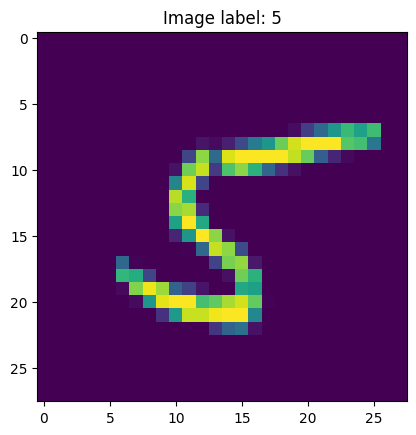

In [45]:
# do not change the code in the block below
# __________start of block__________

train_mnist_data = MNIST('.', train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_mnist_data = MNIST('.', train=False, transform=torchvision.transforms.ToTensor(), download=True)


train_data_loader = torch.utils.data.DataLoader(
    train_mnist_data,
    batch_size=32,
    shuffle=True,
    num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_mnist_data,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f'Image label: {_label}')
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 92% accuracy.

*Комментарий: для этого достаточно линейных слоев и функций активации.*

__Внимание, ваша модель должна быть представлена именно переменной `model`.__

In [46]:
'''
Таким образом, в images у нас хранится батч из 32 картинок с 1 каналом (черно-белая картинка).
Размер картинки в пиксилях 28 на 28.
'''
data_train_iter = iter(train_data_loader)
images, labels = next(data_train_iter)
images.shape

torch.Size([32, 1, 28, 28])

In [47]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(nn.Linear(784, 784), # линейный слой. Принимает на вход картинку 28 на 28, вытянутую в один одномерный вектор
                                               nn.ReLU(), # нелинейная функция активации
                                               nn.Linear(784, 784), 
                                               nn.ReLU(), 
                                               nn.Linear(784, 10), 

                                               #? заметим, что здесь на выходе не нужен softmax
                                               )

    def forward(self, x):
        x = self.flatten(x)
        predictions = self.linear_relu_stack(x)
        return predictions

In [48]:
# Creating model instance
model = NeuralNetwork() # your code here

Локальные тесты для проверки вашей модели доступны ниже:

In [49]:
# do not change the code in the block below
# __________start of block__________
assert model is not None, 'Please, use `model` variable to store your model'

try:
    x = random_batch[0].reshape(-1, 784)
    y = random_batch[1]

    # compute outputs given inputs, both are variables
    y_predicted = model(x)    
except Exception as e:
    print('Something is wrong with the model')
    raise e
    
    
assert y_predicted.shape[-1] == 10, 'Model should predict 10 logits/probas'

print('Everything seems fine!')
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Рекомендуем поработать с различными оптимизаторами.

In [50]:
# your code here

# заведем оптимизатор, котрый будет подстраивать параметры нашей нейронной сети
opt = torch.optim.Adam(model.parameters(), lr=1e-4) # адаптивный градиент
criter = nn.CrossEntropyLoss() # функция потерь

epochs = 10 # количество эпох (то есть, колечество проходов по тренировочному датасету)
loss_history = [] # сюда будем сохранять, как менялось знечение функции потерь по мере обучения

for i in range(epochs):
    for images_batch, lables_batch in train_data_loader:    
        # делаем предсказание модели
        prediction = model(images_batch)
        # считаем значение функции потерь
        loss = criter(prediction, lables_batch)
        
        loss_history.append(loss.item())

        # вычисляем градиенты
        opt.zero_grad()
        loss.backward()

        # делаем шаг градиентного спуска
        opt.step()
    print(f"epoch[{i+1}] loss function is {loss_history[i]}")

epoch[1] loss function is 2.2983946800231934
epoch[2] loss function is 2.29118275642395
epoch[3] loss function is 2.279456615447998
epoch[4] loss function is 2.2852017879486084
epoch[5] loss function is 2.2766058444976807
epoch[6] loss function is 2.2707717418670654
epoch[7] loss function is 2.283416748046875
epoch[8] loss function is 2.2675139904022217
epoch[9] loss function is 2.278547763824463
epoch[10] loss function is 2.247274160385132


Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [51]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in train_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
train_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [52]:
print(f'Neural network accuracy on train set: {train_acc:3.5}')

Neural network accuracy on train set: 0.99728


In [53]:
predicted_labels = []
real_labels = []
model.eval()
with torch.no_grad():
    for batch in test_data_loader:
        y_predicted = model(batch[0].reshape(-1, 784))
        predicted_labels.append(y_predicted.argmax(dim=1))
        real_labels.append(batch[1])

predicted_labels = torch.cat(predicted_labels)
real_labels = torch.cat(real_labels)
test_acc = (predicted_labels == real_labels).type(torch.FloatTensor).mean()

In [54]:
print(f'Neural network accuracy on test set: {test_acc:3.5}')

Neural network accuracy on test set: 0.981


Проверка, что необходимые пороги пройдены:

In [55]:
assert test_acc >= 0.92, 'Test accuracy is below 0.92 threshold'
assert train_acc >= 0.91, 'Train accuracy is below 0.91 while test accuracy is fine. We recommend to check your model and data flow'

### Сдача задания
Загрузите файл `hw07_data_dict.npy` (ссылка есть на странице с заданием) и запустите код ниже для генерации посылки.

In [ ]:
# do not change the code in the block below
# __________start of block__________
import os
import json
assert os.path.exists('hw07_data_dict.npy'), 'Please, download `hw07_data_dict.npy` and place it in the working directory'

def get_predictions(model, eval_data, step=10):
    
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx:idx+step].reshape(-1, 784))
            predicted_labels.append(y_predicted.argmax(dim=1))
    
    predicted_labels = torch.cat(predicted_labels).numpy()
    predicted_labels = ','.join([str(x) for x in list(predicted_labels)])
    return predicted_labels

loaded_data_dict = np.load('hw07_data_dict.npy', allow_pickle=True)

submission_dict = {
    'train': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['train'])),
    'test': get_predictions(model, torch.FloatTensor(loaded_data_dict.item()['test']))
}

with open('submission_dict_hw07.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict_hw07.json`')
# __________end of block__________

На этом задание завершено. Поздравляем!